### Klasyfikacja pojedynczych znaków
Zagadnienie jakie poruszymy w tym notatniku będzie rozpoznawanie cyfr zapisanych pisemem odręcznym. 

Rozpoczniemy od załadowania niezbędnych bibliotek. Będziemy używać biblioteki "Mxnet" do trenowania i testowania sieci neuronowej, która posłuży do rozpoznawania odręcznie zapisanych cyfr pochodzących ze zbioru MNIST.

In [1]:
import mxnet as mx

#### Przygotowanie zbioru danych

Gdy mamy już załadowaną bibiloteke mxnet, możemy przejść dalej do przygotowania danych. Rozpoczynamy od pobrania zbioru danych mnist z podziałem na cześć testową oraz treningową.

In [2]:
mx.random.seed(42)

mnist = mx.test_utils.get_mnist()
batch_size = 100
train_data = mx.io.NDArrayIter(mnist['train_data'], mnist['train_label'], batch_size, shuffle=True)
val_data = mx.io.NDArrayIter(mnist['test_data'], mnist['test_label'], batch_size)

Wykorzystamy architekturę głębokich sieci neuronowych o nazwie perceptron wielowarstwowy (MLP).
Rozpoczynamy od zaimportowania modułu "nn" pochodzącego z biblioteki mxnet.

In [3]:
from __future__ import print_function
from mxnet import gluon
from mxnet.gluon import nn
from mxnet import autograd as ag

#### Definicia sieć perceptron wielowarstwowy
Wykorzystamy podejście wielowarstwowy perceptron do rozwiązania tego problemu. Zdefiniujemy siec MLP wykorzystując biblioteke MXNet.

MLP składają się z kilku w pełni połączonych warstw. W pełni połączona warstwa (ang. Fully connected) lub w skrócie warstwa FC to taka, w której każdy neuron w warstwie jest połączony z każdym neuronem z poprzedniej warstywy.

W MLP wyjścia większości warstw FC są podawane do funkcji aktywacji, która stosuje nieliniowość elementową. Ten krok jest kluczowy i daje sieciom neuronowym możliwość klasyfikowania danych wejściowych, które nie są liniowo rozdzielone. Typowe wybory funkcji aktywacji to sigmoid, tanh i funkcja ReLU. W tym przykładzie użyjemy funkcji aktywacji ReLU, która ma kilka pożądanych właściwości i jest zwykle uważana za wybór domyślny w tego typu przypadkach.

Poniższy kod deklaruje trzy w pełni połączone warstwy po 128, 64 i 10 neuronów. Ostatnia w pełni połączona warstwa często ma swój ukryty rozmiar równy liczbie klas wyjściowych w zestawie danych. Co więcej, te warstwy FC wykorzystują funkcje aktywacji ReLU.

Użyjemy warstwy typu Sequential. To liniowy stos warstw sieci neuronowych. To nic innego jak w pełni połączone warstwy, które zostały omówione powyżej.

In [4]:
net = nn.Sequential()
with net.name_scope():
    net.add(nn.Dense(128, activation='relu'))
    net.add(nn.Dense(64, activation='relu'))
    net.add(nn.Dense(10))

Inicjujemy parametry i optymalizator. Poniższy kod źródłowy inicjalizuje wszystkie parametry otrzymane z parametru dict przy użyciu inicjatora Xavier do trenowania sieci MLP, którą zdefiniowaliśmy powyżej.

Do naszego szkolenia wykorzystamy optymalizator stochastycznego gradientu (SGD). W szczególności będziemy używać mini-partii SGD. Standardowy SGD przetwarza dane po jednym przykładzie na raz. W praktyce jest to bardzo powolne i można przyspieszyć proces, przetwarzając przykłady w małych partiach. W takim przypadku nasza wielkość partii będzie wynosić 100, co jest rozsądnym wyborem. Innym parametrem, który tutaj wybieramy, jest szybkość uczenia się, która kontroluje wielkość kroku, jaki optymalizator przyjmuje w poszukiwaniu rozwiązania. Wybieramy współczynnik uczenia się 0,02. Ustawienie tych parametrów może mieć ogromny wpływ na wyniki treningowe.

Użyjemy klasy Trainer, aby zastosować optymalizator SGD na zainicjowanych parametrach.

In [5]:
ctx = [mx.gpu()]
net.initialize(mx.init.Xavier(magnitude=2.24), ctx=ctx)
trainer = gluon.Trainer(net.collect_params(), 'sgd', {'learning_rate': 0.02})

[15:00:01] ../src/base.cc:80: cuDNN lib mismatch: linked-against version 8201 != compiled-against version 8100.  Set MXNET_CUDNN_LIB_CHECKING=0 to quiet this warning.


#### Trenowanie sieci.
W przypadku tego przykładu przeprowadzimy trening przez 10 epok i zatrzymamy się. Epoka to jedno pełne przejście przez wszystkie dane treningowe.

Szkolenie będzie się odbywało poprzez następujące kroki:

1. Zdefiniuj metrykę oceny dokładności na podstawie danych uczących.

2. Zapętlaj wejścia dla każdej epoki.

3. Przekaż dane wejściowe przez sieć, aby uzyskać dane wyjściowe.

4. Oblicz straty na podstawie danych wyjściowymi i prawdiłowej klasyfikacji w zakresie rekordu.

5. Oblicz SGD w zakresie rekordu.

6. Zaktualizuj metrykę i parametry oceny za pomocą opadania gradientowego.

Funkcja strat bierze pary (wyjście, etykieta) i oblicza stratę skalarną dla każdej próbki w minipartii. Skalary mierzą odległość każdego wyjścia od etykiety. Istnieje wiele predefiniowanych funkcji straty w gluon.loss. Tutaj używamy softmax_cross_entropy_loss do klasyfikacji cyfr. Obliczymy stratę i wykonujemy propagację wsteczną w zakresie szkolenia zdefiniowanym przez autograd.record().

In [6]:
%%time
epoch = 10
# Use Accuracy as the evaluation metric.
metric = mx.metric.Accuracy()
softmax_cross_entropy_loss = gluon.loss.SoftmaxCrossEntropyLoss()
for i in range(epoch):
    # Reset the train data iterator.
    train_data.reset()
    # Loop over the train data iterator.
    for batch in train_data:
        # Splits train data into multiple slices along batch_axis
        # and copy each slice into a context.
        data = gluon.utils.split_and_load(batch.data[0], ctx_list=ctx, batch_axis=0)
        # Splits train labels into multiple slices along batch_axis
        # and copy each slice into a context.
        label = gluon.utils.split_and_load(batch.label[0], ctx_list=ctx, batch_axis=0)
        outputs = []
        # Inside training scope
        with ag.record():
            for x, y in zip(data, label):
                z = net(x)
                # Computes softmax cross entropy loss.
                loss = softmax_cross_entropy_loss(z, y)
                # Backpropagate the error for one iteration.
                loss.backward()
                outputs.append(z)
        # Updates internal evaluation
        metric.update(label, outputs)
        # Make one step of parameter update. Trainer needs to know the
        # batch size of data to normalize the gradient by 1/batch_size.
        trainer.step(batch.data[0].shape[0])
    # Gets the evaluation result.
    name, acc = metric.get()
    # Reset evaluation result to initial state.
    metric.reset()
    print('training acc at epoch %d: %s=%f'%(i, name, acc))

training acc at epoch 0: accuracy=0.778750
training acc at epoch 1: accuracy=0.899683
training acc at epoch 2: accuracy=0.914833
training acc at epoch 3: accuracy=0.923950
training acc at epoch 4: accuracy=0.930300
training acc at epoch 5: accuracy=0.937283
training acc at epoch 6: accuracy=0.942250
training acc at epoch 7: accuracy=0.946417
training acc at epoch 8: accuracy=0.950500
training acc at epoch 9: accuracy=0.953133
CPU times: user 15.5 s, sys: 3.04 s, total: 18.5 s
Wall time: 11.8 s


#### Predykcja
Po zakończeniu powyższego szkolenia możemy ocenić wyszkolony model, uruchamiając predykcje na zestawie danych walidacji. Ponieważ zbiór danych zawiera również prawidłowo sklasyfikowane cyfry dla wszystkich obrazów testowych, możemy obliczyć metrykę dokładności względem danych walidacyjnych w następujący sposób.

In [7]:
# Use Accuracy as the evaluation metric.
metric = mx.metric.Accuracy()
# Reset the validation data iterator.
val_data.reset()
# Loop over the validation data iterator.
for batch in val_data:
    # Splits validation data into multiple slices along batch_axis
    # and copy each slice into a context.
    data = gluon.utils.split_and_load(batch.data[0], ctx_list=ctx, batch_axis=0)
    # Splits validation label into multiple slices along batch_axis
    # and copy each slice into a context.
    label = gluon.utils.split_and_load(batch.label[0], ctx_list=ctx, batch_axis=0)
    outputs = []
    for x in data:
        outputs.append(net(x))
    # Updates internal evaluation
    metric.update(label, outputs)
print('validation acc: %s=%f'%metric.get())
assert metric.get()[1] > 0.94

validation acc: accuracy=0.952500


Jeśli wszystko poszło dobrze, powinniśmy zobaczyć wartość dokładności około 0.96, co oznacza, że jesteśmy w stanie dokładnie przewidzieć cyfrę w 96% obrazów testowych.

#### Badania z własnym pismem odręcznym

Wykonamy teraz badania z własnym pismem. Poniżej zostaną wyświetlone, wykonane przeze mnie cyfry. Cyfry zostały wykonane w programie graficznym na komputerze. Są to cyfry zapisane czarnym markerem na białym tle w rodzielczości 28x28 pikseli. Rozpoczynamy od załadowania bibliotek służacych do przygotowania danych.

In [8]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
import sklearn.preprocessing 

Następnie ładujemy przygotowane zdjęcia i przekształcamy je do tablicy numpy. Tak przygotowane dane dostarczamy do sieci i sprawdzamy rezultat.

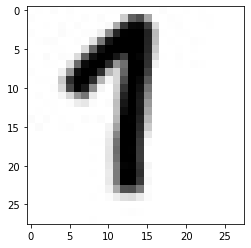

Classification result: 8


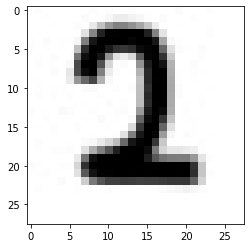

Classification result: 2


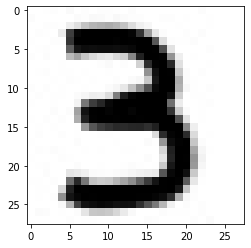

Classification result: 3


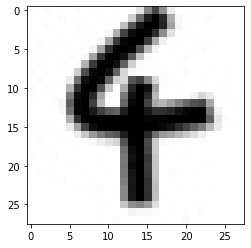

Classification result: 8


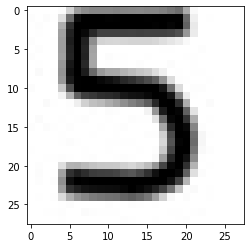

Classification result: 3


In [9]:
for x in range(1, 6):
    img = cv.imread(f'data/{x}.png')[:, :, 0]
    img = np.invert(np.array([img])).astype('float32')    
    for number in np.nditer(img[0], op_flags=['readwrite']):
        for pixel in np.nditer(number, op_flags=['readwrite']):
            if pixel > 0:
                pixel[...] = pixel/255
            else:
                pixel[...] = 0
    plt.imshow(img[0], cmap=plt.cm.binary)
    plt.show()
    img = mx.ndarray.array(img, ctx=mx.gpu(0))
    prediction = net(img).argmax(axis=1).astype('int32').asscalar()
    print(f'Classification result: {prediction}')

#### Badania na zbiorze testowym

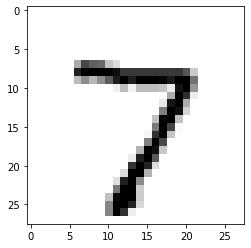

Classification result: 7


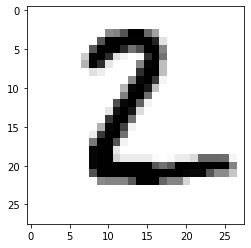

Classification result: 2


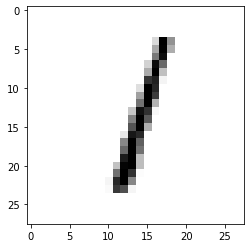

Classification result: 1


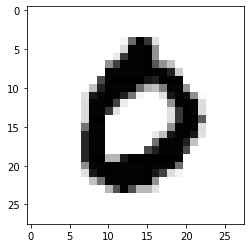

Classification result: 0


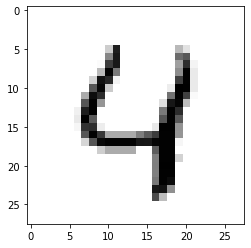

Classification result: 4


In [10]:
mnist = mx.test_utils.get_mnist()
test_data = mnist['test_data']
for x in range(0,5):
    img = test_data[x]
    plt.imshow(img[0], cmap=plt.cm.binary)
    plt.show()
    img = mx.ndarray.array(img, ctx=mx.gpu(0))
    prediction = net(img).argmax(axis=1).astype('int32').asscalar()
    print(f'Classification result: {prediction}')

#### Podsumowanie

Jak widać sieć nie zawsze idealnie radzi sobie z rozpoznawaniem cyfr. Pomimmo wysokiego wyniku dokładności sieci na zbiorze walidacyjnym, tylko 2 z 5 cyfr zostało prawdiłowo sklasyfikowane. Może to być spowodowane innym charakterem pisma, lub zastosowaniem programu graficznego, zamiast np. Ołówka i papieru.